In [1]:

import numpy as np
import matplotlib.pyplot as plt

In [ ]:

class Node:
    def __init__(self):
        self.voltage = 0
        self.connectedComponents = []
        

class Component:
    def __init__(self, value):
        if (value.real != 0):
            Exception("component values are real")
        self.name = "None"
        self.value = value
        self.nodeForward = Node()
        self.nodeForward.connectedComponents.append(self)
        self.nodeBackward = Node()
        self.nodeBackward.connectedComponents.append(self)
        self.current = 0  
        self.impedance = 0

        


class Resistor(Component):
    def __init__(self, resistance):
        super().__init__(resistance)
        
    def setFrequency(self, omega):
        self.impedance = self.value

class Capacitor(Component):
    def __init__(self, capacitance):
        super().__init__(capacitance)
    def setFrequency(self, omega):
        self.impedance = 1 / (1j * omega * self.value)
class VoltageSource(Component):
    def __init__(self, value):
        super().__init__(value)
    def setFrequency(self, omega):
        self.impedance = None

class GroundNode(Node):
    """
    Special node that is always at 0 V.
    Any attempt to set voltage is ignored.
    """
    def __init__(self):
        super().__init__()
        self.voltage = 0
    
    @property
    def voltage(self):
        return 0
    
    @voltage.setter
    def voltage(self, val):
        # Ignore any attempts to set ground voltage
        pass

class DependentVoltageSource(VoltageSource):
    # gain and component
    # always doing nodeForward- nodeBackward
    def __init__(self, value, comp):  
        super().__init__(value)
        self.comp = comp    
    

class Circuit:
    def __init__(self):
        self.ground = GroundNode()      # Create a dedicated ground node
        self.components = []
        # Keep track of all nodes, including ground
        self.nodes = set([self.ground])
        self.angularFrequency = 0

    def addComponent(self, component):
        
        self.components.append(component)
        self.nodes.add(component.nodeForward)
        self.nodes.add(component.nodeBackward)
        
        
    def connectOPAmp(self, op, c1, c2, c3)
    def connectComponents(self, comp1, comp2, connectType="FB"):
        """
        Merges comp1.nodeForward with comp2.nodeBackward.
        If either one is the ground node, that node remains the merged node.
        Otherwise a new node is created for the merge.
        """
        if connectType == "FB":
            node1 = comp1.nodeForward
            node2 = comp2.nodeBackward
        elif connectType == "FF":
            node1 = comp1.nodeForward
            node2 = comp2.nodeForward
        elif connectType == "BB":
            node1 = comp1.nodeBackward
            node2 = comp2.nodeBackward

        if node1 == node2:
            return  # Already the same node, nothing to do

        # If either side is already ground, keep ground as the merged node
        if isinstance(node1, GroundNode) and isinstance(node2, GroundNode):
            return
        elif isinstance(node1, GroundNode):
            merged_node = node1
            removed_node = node2
        elif isinstance(node2, GroundNode):
            merged_node = node2
            removed_node = node1
        else:
            # Neither is ground, so create a new node
            merged_node = Node()
            removed_node = None
        
        if removed_node:
            # Merge all connectedComponents of removed_node into merged_node
            merged_node.connectedComponents += removed_node.connectedComponents
            for comp in removed_node.connectedComponents:
                if comp.nodeForward == removed_node:
                    comp.nodeForward = merged_node
                if comp.nodeBackward == removed_node:
                    comp.nodeBackward = merged_node
            self.nodes.discard(removed_node)
        else:
            # We actually merge node1 and node2 into a brand-new node
            merged_node.connectedComponents = node1.connectedComponents + node2.connectedComponents
            for comp in merged_node.connectedComponents:
                if comp.nodeForward in (node1, node2):
                    comp.nodeForward = merged_node
                if comp.nodeBackward in (node1, node2):
                    comp.nodeBackward = merged_node
            self.nodes.discard(node1)
            self.nodes.discard(node2)
            self.nodes.add(merged_node)

    def connectNodeToGround(self, node):
        """
        Explicitly merge any existing node with the ground node.
        Useful if you decide to ground a node after creation.
        """
        if node is self.ground:
            # Already ground, nothing to do
            return
        
        # Merge all connectedComponents of 'node' into the ground node
        self.ground.connectedComponents += node.connectedComponents
        # Update each component that was connected to 'node'
        for comp in node.connectedComponents:
            if comp.nodeForward == node:
                comp.nodeForward = self.ground
            if comp.nodeBackward == node:
                comp.nodeBackward = self.ground
        
        # Remove the old node from the circuit
        self.nodes.discard(node)

    def setCircuitFrequency(self, omega):
        self.angularFrequency = omega
        for component in self.components:
            component.setFrequency(omega)

        
    def solveSystem(self):
        if not self.nodes:
            raise ValueError("No nodes in the circuit.")
        if not self.components:
            raise ValueError("No components in the circuit.")

        ref_node = self.ground
        # Our node-unknowns are all non-ground nodes
        non_ref_nodes = [n for n in self.nodes if n is not ref_node]
        num_nodes = len(non_ref_nodes)
     

        # Partition out voltage sources
        v_sources = [c for c in self.components 
                     if isinstance(c, VoltageSource) and not isinstance(c, DependentVoltageSource)]
        num_v_sources = len(v_sources)

        # Partition out dependent sources
        dep_sources = [c for c in self.components if isinstance(c, DependentVoltageSource)]
        num_d_sources = len(dep_sources)

        # Construct system A x = b
        size = num_nodes + num_v_sources + num_d_sources
        A = np.zeros((size, size), dtype=complex)
        b = np.zeros(size, dtype=complex)
        
        # Create node index mapping
        node_indices = {node: idx for idx, node in enumerate(non_ref_nodes)}
        # 1) KCL for each non-reference node
    
        for node_idx, node in enumerate(non_ref_nodes):
            for comp in node.connectedComponents:
                # Figure out the "other" node for this component
                if comp.nodeForward == node:
                    other_node = comp.nodeBackward
                else:
                    other_node = comp.nodeForward

                # set admittance 
                if isinstance(comp, (Resistor, Capacitor)) and comp.impedance != 0:
                    admittance = 1.0 / comp.impedance

                    A[node_idx, node_idx] += admittance
                    if other_node in node_indices:
                        A[node_idx, node_indices[other_node]] -= admittance


        for vsrc_idx, vsrc in enumerate(v_sources):
            row = num_nodes + vsrc_idx
            n_plus = vsrc.nodeForward
            n_minus = vsrc.nodeBackward

            # Enforce V(n_plus) - V(n_minus) = source voltage
            if n_plus in node_indices:
                A[row, node_indices[n_plus]] = 1
            if n_minus in node_indices:
                A[row, node_indices[n_minus]] = -1
            b[row] = vsrc.value

            # Also, we add a column for the source current:
            # KCL in the node equations: +I at node_plus, -I at node_minus
            current_var_col = num_nodes + vsrc_idx
            if n_plus in node_indices:
                A[node_indices[n_plus], current_var_col] += 1
            if n_minus in node_indices:
                A[node_indices[n_minus], current_var_col] -= 1

        # 3) Dependent Voltage Source equations
        for dsrc_idx, dsrc in enumerate(dep_sources):
            row = num_nodes + num_v_sources + dsrc_idx
            n_plus = dsrc.nodeForward
            n_minus = dsrc.nodeBackward
            gain = dsrc.value

            # KCL-like: V(n_plus) - V(n_minus) - gain * [V(comp.nodeForward) - V(comp.nodeBackward)] = 0
            if n_plus in node_indices:
                A[row, node_indices[n_plus]] += 1
            if n_minus in node_indices:
                A[row, node_indices[n_minus]] -= 1

            # controlling voltage
            ctrl_plus = dsrc.comp.nodeForward
            ctrl_minus = dsrc.comp.nodeBackward
            if ctrl_plus in node_indices:
                A[row, node_indices[ctrl_plus]] += gain
            if ctrl_minus in node_indices:
                A[row, node_indices[ctrl_minus]] -= gain

            # The dependent source has a current variable as well:
            current_var_col = num_nodes + num_v_sources + dsrc_idx
            if n_plus in node_indices:
                A[node_indices[n_plus], current_var_col] += 1
            if n_minus in node_indices:
                A[node_indices[n_minus], current_var_col] -= 1
 
        x = np.linalg.solve(A, b)
        
        # Update variables
        for node, idx in node_indices.items():
            node.voltage = x[idx]

        # Assign currents through voltage sources (including dependent sources)
        for i, vsrc in enumerate(v_sources):
            vsrc.current = x[num_nodes + i]
        for i, dsrc in enumerate(dep_sources):
            dsrc.current = x[num_nodes + num_v_sources + i]

        # Finally, for passive components, compute their current from node voltages
        for comp in self.components:
            if isinstance(comp, (Resistor, Capacitor)) and comp.impedance != 0:
                v_plus = comp.nodeForward.voltage
                v_minus = comp.nodeBackward.voltage
                comp.current = (v_plus - v_minus) / comp.impedance
            



In [15]:
def generateLowPassFilter(resistance, capacitance, voltage):
    
    R = Resistor(resistance)  
    C = Capacitor(capacitance)  
    Vs = VoltageSource(voltage)  
   
    circuit = Circuit()
    circuit.connectNodeToGround(Vs.nodeBackward)
    circuit.addComponent(Vs)
    circuit.addComponent(R)
    circuit.addComponent(C)
    
    circuit.connectComponents(Vs, R)
    circuit.connectComponents(R, C)
    circuit.connectComponents(C, Vs)  
    
    frequencies = np.logspace(0, 5, 200)  # 1Hz to 100kHz
    magnitudes = []
    phases = []
    
    for f in frequencies:
        omega = 2 * np.pi * f
        
        circuit.setCircuitFrequency(omega)
        
        circuit.solveSystem()
        
        V_in = Vs.nodeForward.voltage - Vs.nodeBackward.voltage
        V_out = C.nodeForward.voltage - C.nodeBackward.voltage

        H = V_out / V_in if abs(V_in) > 1e-9 else 0
        magnitudes.append(20 * np.log10(np.abs(H)))
        phases.append(np.angle(H, deg=True))

generateLowPassFilter(1000, 1e-3, 5)

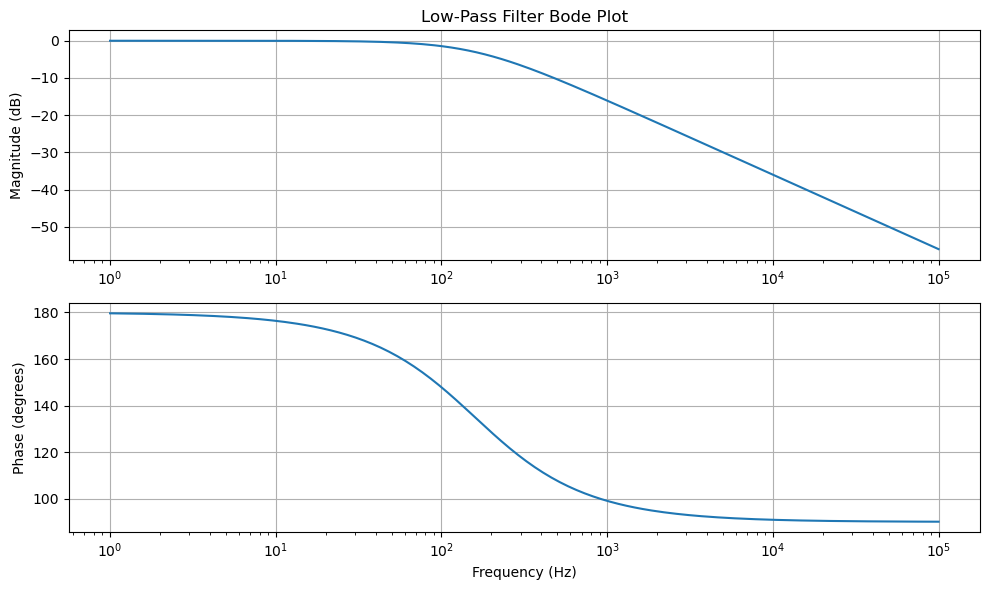

In [16]:
def generateLowPassFilter(resistance, capacitance, voltage):
    R = Resistor(resistance)
    C = Capacitor(capacitance)
    Vs = VoltageSource(voltage)

    # Build circuit
    circuit = Circuit()
    
    circuit.addComponent(Vs)
    circuit.addComponent(R)
    circuit.addComponent(C)

    circuit.connectNodeToGround(Vs.nodeBackward)
    circuit.connectComponents(Vs, R)  
    circuit.connectComponents(R, C)   

    circuit.connectNodeToGround(C.nodeForward)
    
  
    # Sweep frequency
    frequencies = np.logspace(0, 5, 200)  # 1 Hz to 100 kHz
    magnitudes = []
    phases = []

    for f in frequencies:
        omega = 2 * np.pi * f
        circuit.setCircuitFrequency(omega)
        circuit.solveSystem()

        # Extract input and output voltages
        V_in = Vs.nodeForward.voltage - Vs.nodeBackward.voltage
        V_out = C.nodeForward.voltage - C.nodeBackward.voltage

        H = V_out / V_in if abs(V_in) > 1e-9 else 0
        magnitudes.append(20 * np.log10(np.abs(H)))
        phases.append(np.angle(H, deg=True))

    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Magnitude plot
    plt.subplot(2, 1, 1)
    plt.semilogx(frequencies, magnitudes)
    plt.title('Low-Pass Filter Bode Plot')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    
    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(frequencies, phases)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the plot generator
generateLowPassFilter(resistance=1000, capacitance=1e-6, voltage=5)


In [ ]:


def amplificationTest(r1, r2, v=5, rin = 1e10, rout = 1e-10, g = 1e12):
    circuit = Circuit()
    R1 = Resistor(r1)
    R2 = Resistor(r2)
    Rin = Resistor(rin)
    Rout = Resistor(rout)
    V = VoltageSource(v)
    dep = DependentVoltageSource(g, Rin)
    comp = [R1, R2, Rin, Rout, V, dep]
    for c in comp:
        circuit.addComponent(c)
    
    circuit.connectNodeToGround(R1.nodeBackward)
    circuit.connectNodeToGround(V.nodeBackward)
    circuit.connectNodeToGround(dep.nodeBackward)
    circuit.connectComponents(V, Rin)
    circuit.connectComponents(Rin, R2)
    circuit.connectComponents(R1, R2)
    circuit.connectComponents(Rout, R2, connectType="FF")
    circuit.connectComponents(dep, Rout)
    
    circuit.setCircuitFrequency(0)
    circuit.solveSystem()
    
    print(Rout.nodeForward.voltage)

amplificationTest(1000, 1000)

(9.99999999998+0j)


In [18]:
def dependentSourceTest(r1,r3,gain,v):
    R1 = Resistor(r1)

    R3 = Resistor(r3)
    depVoltage = DependentVoltageSource(gain, R1)
    voltage = VoltageSource(v)
    
    circuit = Circuit()
    
    circuit.addComponent(R1)

    circuit.addComponent(R3)
    circuit.addComponent(depVoltage)
    circuit.addComponent(voltage)
    
 
    
    circuit.connectComponents(voltage, R1)
    circuit.connectComponents(R1, voltage)
    
    circuit.connectComponents(R1, depVoltage)
    
    
    circuit.connectComponents(depVoltage, R3)
    circuit.connectComponents(R3, depVoltage)
    circuit.setCircuitFrequency(0)
    circuit.solveSystem()
    
    print(depVoltage.nodeForward.voltage)
    
    

dependentSourceTest(1000,1000,100000,5)

(499998.0138549805+0j)


LinAlgError: Singular matrix